In [41]:
import os
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
from keras.utils import plot_model
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input
from keras.models import Model
import string
import numpy as np
from pickle import load
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM ,GRU
from keras.layers import Embedding
from keras.layers import Dropout, Reshape, Lambda, Concatenate
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu

emb_dim = 50
snaphot_folder = 'weights3/'
batch_size = 32

In [2]:
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [3]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return list(set(dataset))

def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

#### Reading the captions

In [4]:
doc = load_doc("data/Flickr8k.token.txt")

In [5]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except :
        print(line)

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


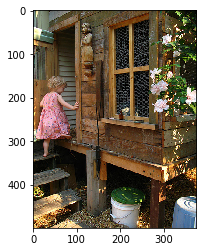

In [6]:
print(next(iter(descriptions)),descriptions[next(iter(descriptions))])

x = plt.imread('data/Flicker8k_Dataset/'+next(iter(descriptions))+'.jpg')
plt.imshow(x)
plt.show()

#### Cleaning the data

In [7]:
def clean_data(pairs):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>0]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [8]:
descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions_clean))]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

#### Adding start and end token to the sequence of words

In [9]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [10]:
descriptions_tokenSE = add_end_start_tokens(descriptions_clean)
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way <endseq>',
 '<startseq> a girl going into a wooden building <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin <endseq>']

#### Loading train captions

In [11]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
        
    return dataset_

In [12]:
train_imgs_addr = 'data/Flickr_8k.trainImages.txt'
test_imgs_addr = 'data/Flickr_8k.testImages.txt'
dev_imgs_addr = 'data/Flickr_8k.devImages.txt'

train_imgs_names = load_set(train_imgs_addr)
test_imgs_names = load_set(test_imgs_addr)
dev_imgs_names = load_set(dev_imgs_addr)

len(train_imgs_names), len(test_imgs_names), len(dev_imgs_names)

(6000, 1000, 1000)

In [13]:
train_descriptions = load_train_test(descriptions_tokenSE, train_imgs_names)
dev_descriptions = load_train_test(descriptions_tokenSE, dev_imgs_names)
test_descriptions = load_train_test(descriptions_tokenSE, test_imgs_names)

#### reoccuring vocab

In [14]:
# making a vocabulary of the words that occur more than word_count_threshold time
def create_reoccurring_vocab(descriptions, word_count_threshold = 10):
    # Create a list of all the captions
    all_captions = []
    for key, val in descriptions.items():
        for cap in val:
            all_captions.append(cap)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    return vocab

In [15]:
vocab = create_reoccurring_vocab(train_descriptions, word_count_threshold = 5)
sorted(vocab)[:10]

['<endseq>',
 '<startseq>',
 'a',
 'about',
 'above',
 'accordion',
 'acrobatic',
 'across',
 'act',
 'action']

In [16]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
tokenizer = keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 2535


In [17]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

#### finding suitable length for sequences to use in training

In [18]:
# finding the maximum length of questions and answers
# because there are senteces with unusually long lengths, 
# we caculate the max length that p% of data can be placed in
def max_length(desc,p):
    all_desc = []
    # Create a list of all the captions
    for i in desc:
        for j in desc[i]:
            all_desc.append(j)

    length_all_desc = list(len(d.split()) for d in all_desc)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_desc, p)))
    print('longest sentence: ', max(length_all_desc))

    return int(np.percentile(length_all_desc, p))

max_length = max_length(train_descriptions,90)

print('max-len answer for training: ', max_length)

percentile 90 of len of questions: 18.0
longest sentence:  37
max-len answer for training:  18


In [19]:
# [hi i am home]
# [0 0 0 0 0 0 0 0 0 0 0 50 60 70 80]

In [20]:
# only keep the decriptions that have the words from our vocab
def trimRareWords(desc):
    num_des = 0
    num_trim = 0
    desc_result = desc.copy()
    for d in desc_result:
        desc_result[d]=[]
        
    # Filter out pairs with trimmed words
    i=0
    for d in desc:
        i+=1
        progressBar(value=i, endvalue=len(desc))
        for p in desc[d]:
            num_des += 1
            keep_input = True
            # Check input sentence
            for word in p.split(' '):
                if word not in vocab:
                    keep_input = False
                    break

            # Only keep descriptions that do not contain trimmed word(s) in them
            if keep_input:
                num_trim += 1
                desc_result[d].append(p)

    print("\nTrimmed from {} pairs to {}".format(num_des, num_trim))
    return desc_result


# Trim voc and pairs
# desc_train_final = trimRareWords(train_descriptions)
# with open ('train_descriptions.pkl','wb') as f:
#     pickle.dump(desc_train_final,f)
    
# with open ('train_descriptions.pkl','rb') as f:
#     desc_train_final = pickle.load(f)
    
# len(desc_train_final)

#### feature extractor model Xception

In [61]:
xception = Xception()
extractor = Model(inputs=xception.inputs, outputs=xception.layers[-2].output) # removing 2 last fully connected layers 
print(extractor.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [62]:
def extract_features(description, model, inpute_size = (229,229)):
    directory = 'data\\Flicker8k_Dataset'
    features = {}
    i = 0
    for name in description:
        progressBar(value=i,endvalue=len(descriptions))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature.reshape(2048)
    return features

In [21]:
# train_features = extract_features(train_descriptions, extractor)
# test_features = extract_features(test_descriptions, extractor)
# dev_features = extract_features(dev_descriptions, extractor)

# pickle.dump(train_features, open('train_features.pkl', 'wb'))
# pickle.dump(test_features, open('test_features.pkl', 'wb'))
# pickle.dump(dev_features, open('dev_features.pkl', 'wb'))
with open('dev_features.pkl','rb') as f:
    dev_features= pickle.load(f)    
with open('train_features.pkl','rb') as f:
    train_features= pickle.load(f)
with open('test_features.pkl','rb') as f:
    test_features= pickle.load(f)


#### Data Genarator

![](model_v2.png)

In [38]:
# outputs a batch of captions-pictures
def data_generator(descriptions, photos):
    X1, X2, y = [], [], []
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # find the index of each word of the caption in vocabulary
                seq = tokenizer.texts_to_sequences(desc.split())
                # split one sequence into multiple X, y pairs
                # Each step of the following for loop selects one word
                # from the caption, consider that word as y and
                # all the words before that will be the X
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == batch_size:
                yield [[np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1)]
                X1, X2, y = list(), list(), list()
                n=0

In [39]:
d = next(data_generator(dev_descriptions, dev_features))
d[0][0].shape, d[0][1].shape, d[1].shape

((1974, 2048), (1974, 18), (1974,))

#### Word Emeddings glove 

I used wikipedia corpus that includes 400k words in 50d 

download from here: https://github.com/stanfordnlp/GloVe

In [24]:
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix 
    else:
        glove_dir = '../glove'
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get x-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        print('GloVe loaded!')
        
    embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

In [25]:
# in order to make model faster, I load embd outside the make_model
embedding_layer = make_embedding_layer(emb_dim, glove=True)

GloVe loaded!


#### loss

In [26]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

#### Constructing the model

In [27]:
from keras.layers import RepeatVector
def make_model(embedding ,dout= 0.2, feature_size= 2048, units= 256):
    
    features = Input(shape=(feature_size,)) # output size of feature extractor
    X_fe_one_dim = Dense(units, activation='relu')(features) # because i have used bidirectional LSTM, the number of units should
                                                   # become double here in order for the add function to work
    X_fe = RepeatVector(max_length)(X_fe_one_dim)
    X_fe = Dropout(dout)(X_fe)
    
    seq = Input(shape=(max_length,))
    X_seq = embedding(seq)
    X_seq = Lambda(lambda x: x, output_shape=lambda s:s)(X_seq) # remove mask from the embedding cause concat doesn't support it
    X_seq = Dropout(dout)(X_seq)
    X_seq = Concatenate(name='concat_features_word_embeddings', axis=-1)([X_fe,X_seq])
    X_seq = GRU(units, return_sequences=True)(X_seq,initial_state=X_fe_one_dim) # passing features as init_state
    X_seq = Dropout(dout + 0.2)(X_seq)
    X_seq = GRU(units, return_sequences=False)(X_seq)

    outputs = Dense(vocab_size, activation='softmax')(X_seq)

    # merge the two input models
    model = Model(inputs=[features, seq], outputs = outputs, name='model_with_features_each_step')
    return model

#### compiling the model

In [45]:
model = make_model(embedding_layer)
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          524544      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 18, 50)       126750      input_4[0][0]                    
______________________________________________________________________

In [46]:
# plot_model(model, to_file='model3.png', show_shapes=True)

In [47]:
model.compile(loss=masked_loss_function, optimizer= 'adam')

#### Training the model

In [43]:
history={'loss':[], 'BLEU_val':[]}

In [31]:
# generate a description for an image greedy way
def generate_desc(model, photo_fe, inference= False):
    # seed the generation process
    in_text = start_token
    # iterate over the whole length of the sequence
    # generate one word at each iteratoin of the loop
    # appends the new word to a list and makes the whole sentence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences(in_text.split()) #[wordtoix[w] for w in in_text.split() if w in wordtoix]
        # pad input
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        # predict next word
        yhat = model.predict([photo_fe,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next v
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == end_token:
            break
            
    if inference == True:
        in_text = in_text.split()
        if len(in_text) == max_length:
            in_text = in_text[1:] # if it is already at max len and endseq hasn't appeared
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text)
        
    return in_text

In [32]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [33]:
# calculating BLEU score of predictions
def evaluate_model(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    for key, desc_list in descriptions.items():
        # generate description
        i+=1
        progressBar(i, len(descriptions), bar_length=20,job='Evaluating')
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

In [34]:
from keras.callbacks import ReduceLROnPlateau
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)

====


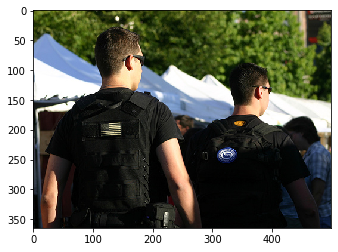

Greedy: grocery digs grocery digs digs grocery digs grocery digs grocery digs digs grocery digs grocery digs grocery


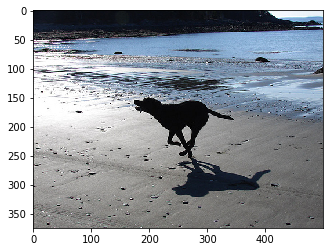

Greedy: opens opens opens opens opens bush daughter daughter daughter daughter daughter daughter daughter daughter daughter daughter daughter


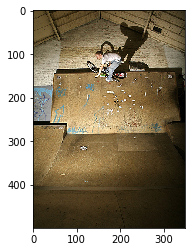

Greedy: splashing splashing splashing bows splashing bows splashing splashing bows splashing splashing bows splashing splashing bows splashing splashing


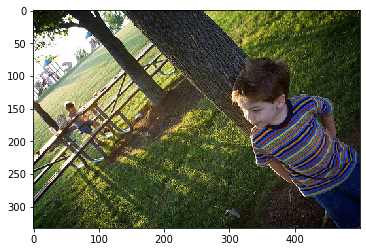

Greedy: crashing cheer matching matching crashing cheer matching matching crashing cheer cheer matching matching crashing cheer matching matching
====


In [36]:
def test(i=np.random.randint(len(test_features)), j=np.random.randint(len(test_features)),
         k=np.random.randint(len(test_features)), q=np.random.randint(len(test_features)), show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[j]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[k]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:", generate_desc(model, fe, inference=True))
    pic = list(test_features.keys())[q]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    print('====')
    
    
test(show_pic=True)    

In [ ]:
steps = len(train_descriptions)//batch_size

In [ ]:
# create the data generator
generator = data_generator(train_descriptions, train_features)

In [48]:
ep=1

In [49]:
for i in range(ep, 100):
    
    print('Epoch :',i,'\n')
    # fit for one epoch
    h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])
    
    # save model every 3 epochs
    if i % 3 == 0:
        test() 
        model.save_weights(snaphot_folder+'/model_' + str(i) + '.h5')
        belus= evaluate_model(model, dev_descriptions, dev_features, K_beams=1)    
        history['BLEU_val'].append((belus,i))

    print('\n','='*80)

Epoch : 1 

Epoch 1/1
187/187 [==============================] - 23s 122ms/step - loss: 5.2748

Epoch : 2 

Epoch 1/1
187/187 [==============================] - 22s 120ms/step - loss: 5.0752

Epoch : 3 

Epoch 1/1
187/187 [==============================] - 23s 121ms/step - loss: 4.4940
====
Greedy: a man in a <UNK> and a <UNK>
Greedy: a dog is running in a water
Greedy: a man is is is is is is is is is is
Greedy: a girl girl in a <UNK>
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.553006
BLEU-2: 0.348993
BLEU-3: 0.232978
BLEU-4: 0.108091

Epoch : 4 

Epoch 1/1
187/187 [==============================] - 23s 121ms/step - loss: 3.7087

Epoch : 5 

Epoch 1/1
187/187 [==============================] - 23s 123ms/step - loss: 3.3901

Epoch : 6 

Epoch 1/1
187/187 [==============================] - 23s 124ms/step - loss: 3.2047
====
Greedy: a man in a black shirt and a hat and a woman in a black shirt and
Greedy: a black dog is running on the beach
Greedy: a man is jumping

187/187 [==============================] - 24s 128ms/step - loss: 1.9454
====
Greedy: a man wearing a black jacket and a knit jacket is holding a cup
Greedy: a black dog and a black dog are walking on the beach
Greedy: a man is doing a trick on a <UNK> covered covered covered covered wall
Greedy: a boy in a red shirt is hanging on a tree branch
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.601676
BLEU-2: 0.400110
BLEU-3: 0.299127
BLEU-4: 0.172148

Epoch : 58 

Epoch 1/1
187/187 [==============================] - 23s 125ms/step - loss: 1.9392

Epoch : 59 

Epoch 1/1
187/187 [==============================] - 24s 128ms/step - loss: 1.9316

Epoch : 60 

Epoch 1/1
187/187 [==============================] - 23s 125ms/step - loss: 1.9218
====
Greedy: a man with a <UNK> face and a <UNK> is wearing a green jacket
Greedy: a black dog and a black dog run along the beach
Greedy: a person is jumping over a <UNK> on his bike
Greedy: a little girl in a striped shirt is hanging u

Greedy: a man is jumping over a rock on his bike
Greedy: a young girl wearing a red shirt climbs on a tree branch
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.580556
BLEU-2: 0.377169
BLEU-3: 0.276164
BLEU-4: 0.154587

Epoch : 85 

Epoch 1/1
187/187 [==============================] - 23s 125ms/step - loss: 1.7796

Epoch : 86 

Epoch 1/1
187/187 [==============================] - 24s 127ms/step - loss: 1.7756

Epoch : 87 

Epoch 1/1
187/187 [==============================] - 24s 127ms/step - loss: 1.7747
====
Greedy: a man in a black jacket is looking at the camera
Greedy: a black dog and a black dog are walking on the beach
Greedy: a person is jumping over a rock on his skateboard
Greedy: a little boy in a red shirt is climbing a tree
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.585656
BLEU-2: 0.385620
BLEU-3: 0.282925
BLEU-4: 0.158612

Epoch : 88 

Epoch 1/1
187/187 [==============================] - 23s 124ms/step - loss: 1.7703

Epoch : 89 

In [50]:
import pickle

with open('hisory_image_caption.pkl','wb') as f:
    pickle.dump(history, f) 

#### Test the model

In [51]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.591937
BLEU-2: 0.395586
BLEU-3: 0.297730
BLEU-4: 0.173237


[0.5919372339537601,
 0.39558553385457157,
 0.2977295339553239,
 0.1732368434955038]

In [53]:
# apprently model overfits badly after epoch 100. so im just gonna use the model from 60th epoch
i=60

model.load_weights(snaphot_folder+'/model_' + str(i) + '.h5')

In [54]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.614497
BLEU-2: 0.418689
BLEU-3: 0.313693
BLEU-4: 0.183087


[0.6144967309710226,
 0.41868928591796206,
 0.3136926357258249,
 0.18308696727187457]

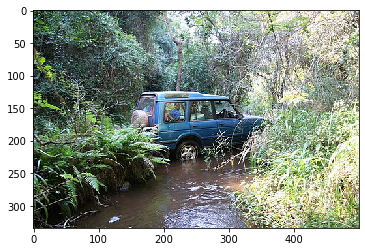

Greedy: a jeep is driving through a mud puddle
Beam K= 3: a yellow jeep is driving through a mud puddle
Beam K= 5: a man drives a jeep through a forest
Beam log K= 3: a jeep is driving through a mud puddle
Beam log K= 5: a jeep is driving through a mud puddle


In [55]:
pic = list(test_features.keys())[560]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

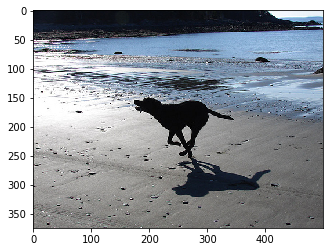

Greedy: black dog is walking along the edge of the ocean
Beam K= 3: black dog stands on the edge of the ocean
Beam K= 5: black dog stands on the edge of body of water
Beam log K= 3: black and white dog is walking on the beach
Beam log K= 5: black and tan dog stands on the edge of large body of water


In [272]:
# 2417745327_a2c2705043.jpg#0	A brown dog runs through the water as a wave comes .
# 2417745327_a2c2705043.jpg#1	A brown dog runs through the water in the ocean .
# 2417745327_a2c2705043.jpg#2	A dog is running through the ocean .
# 2417745327_a2c2705043.jpg#3	The brown dog is running in the water .
# 2417745327_a2c2705043.jpg#4	The brown dog is running parallel to the waves in the water .

pic = list(test_features.keys())[2]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

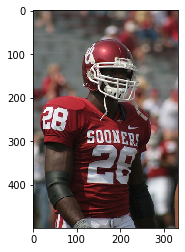

Greedy: football player in sooners uniform is being by the sidelines
Beam K= 3: football player in sooners uniform is running on the sidelines
Beam K= 5: football player in sooners uniform sooners
Beam log K= 3: closeup of football player in sooners uniform
Beam log K= 5: closeup of football player in sooners uniform


In [307]:
# 241347760_d44c8d3a01.jpg#0	A man is wearing a Sooners red football shirt and helmet .
# 241347760_d44c8d3a01.jpg#1	A Oklahoma Sooners football player wearing his jersey number 28 .
# 241347760_d44c8d3a01.jpg#2	A Sooners football player weas the number 28 and black armbands .
# 241347760_d44c8d3a01.jpg#3	Guy in red and white football uniform
# 241347760_d44c8d3a01.jpg#4	The American footballer is wearing a red and white strip .
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

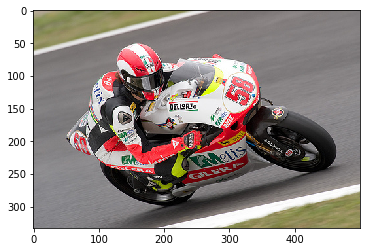

Greedy: motorcycle racer speeds around curve
Beam K= 3: motorcycle racer speeds around curve
Beam K= 5: motorcycle racer speeds around curve
Beam log K= 3: motorcycle racer speeds around curve
Beam log K= 5: motorcycle racer speeds around curve


In [289]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

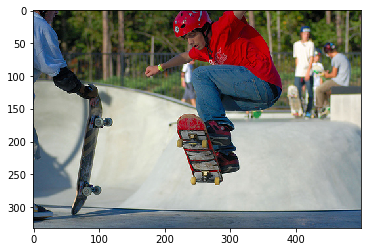

Greedy: man in red shirt and white pants is riding skateboard
Beam K= 3: skateboarder in red shirt is doing trick on his snowboard
Beam K= 5: the skateboarder is doing trick on his skateboard
Beam log K= 3: skateboarder in red shirt is doing trick on his skateboard
Beam log K= 5: skateboarder in red shirt is doing trick on his skateboard


In [308]:


pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

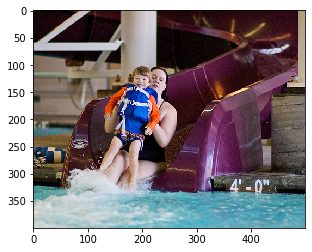

Greedy: boy in blue shorts is splashing in the water
Beam K= 3: the boy is wearing blue hat and is splashing through the water
Beam K= 5: young boy running through water
Beam log K= 3: boy in blue shorts is splashing in the water
Beam log K= 5: the boy is wearing blue shirt and is splashing in the water


In [309]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

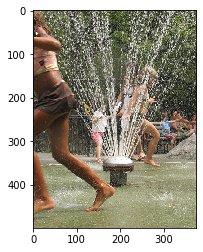

Greedy: little boy in blue shorts is splashing water in puddle
Beam K= 3: the little boy is playing in the muddy water
Beam K= 5: the little boy is standing on the edge of the edge of beach
Beam log K= 3: the little boy is playing in water fountain
Beam log K= 5: the little boy is playing in water puddle


In [276]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

In [1]:
import matplotlib.pyplot as plt

In [13]:
epochs_bleu=[i*3 for i in range(1,34)]
len(epochs_bleu)

33

In [14]:
len(hist_bleu)

33

In [17]:
hist = [553, 605, 614, 620, 596, 605, 617, 613, 620,613, 612, 614, 610, 603, 616, 605, 593, 602, 601, 611, 606, 606, 594, 593, 600,601, 590, 580, 585, 582, 580, 583, 581]

hist_bleu = [i/1000 for i in hist]

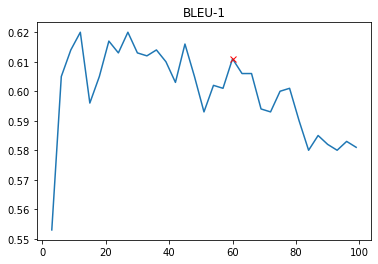

In [34]:
plt.plot(epochs_bleu,hist_bleu)
plt.plot(60, hist_bleu[19], 'rx')
plt.title('BLEU-1')
plt.savefig('bleu1.png')
plt.show()